In [4777]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [4778]:
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4779]:
def label_count(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [4780]:
def prepare_data(ticker):
    base_path = "/content/drive/My Drive"
    stock_price = pd.read_csv(f"{base_path}/dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()

    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    stock_price['200_ma'] = stock_price['prv_close'].rolling(window=200, min_periods=1).mean()
    stock_price['50_ma'] = stock_price['prv_close'].rolling(window=50, min_periods=1).mean()

    stock_news = pd.read_csv(f"{base_path}/dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0
    stock_news['neg_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_mean'] = np.nan
    stock_news['pos_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_mean'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [label_count(['positive']), label_count(['negative'])], '200_ma': 'first', '50_ma': 'first',
        'sentiment_score': 'mean', 'pos_score': 'mean', 'neg_score': 'mean', 'pos_mean': 'mean', 'neg_mean': 'mean'
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative',
                           '200_ma', '50_ma', 'all_score', 'pos_score', 'neg_score', 'pos_mean', 'neg_mean']
    return relation_gp

In [4781]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'NVDA']
ticker = tickers[0]
relation_gp = prepare_data(ticker)
relation_gp

<ipython-input-4779-cc6a419d00d3>:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


,trade_date,prv_close,delta,close,open,high,low,positive,negative,200_ma,50_ma,all_score,pos_score,neg_score,pos_mean,neg_mean
0,2022-10-31,0.00,0.00,153.34,153.155,154.240,151.92,0.275862,0.137931,0.000000,0.000000,0.096446,0.220498,-0.124052,0.799306,-0.899377
1,2022-11-01,153.34,-2.69,150.65,155.080,155.450,149.13,0.166667,0.277778,153.340000,153.340000,-0.085231,0.146493,-0.231724,0.878957,-0.834206
2,2022-11-02,150.65,-5.62,145.03,148.945,152.170,145.00,0.285714,0.142857,151.995000,151.995000,0.103546,0.238440,-0.134894,0.834540,-0.944261
3,2022-11-03,145.03,-6.15,138.88,142.060,142.800,138.75,0.117647,0.529412,149.673333,149.673333,-0.348146,0.090076,-0.438222,0.765643,-0.827752
4,2022-11-04,138.88,-0.50,138.38,142.090,142.670,134.38,0.117647,0.352941,146.975000,146.975000,-0.214672,0.083690,-0.298362,0.711366,-0.845359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-10-23,235.86,-5.10,230.76,234.080,235.144,227.76,0.500000,0.333333,200.375500,226.301000,0.085070,0.404759,-0.319689,0.809518,-0.959066
498,2024-10-24,230.76,-0.19,230.57,229.980,230.820,228.41,0.600000,0.000000,200.601500,226.490800,0.525094,0.525094,0.000000,0.875157,0.000000
499,2024-10-25,230.57,0.84,231.41,229.740,233.220,229.57,0.400000,0.200000,200.828650,226.667800,0.233975,0.330385,-0.096410,0.825962,-0.482050
500,2024-10-28,231.41,1.99,233.40,233.320,234.730,232.55,0.400000,0.000000,201.054750,226.801600,0.274372,0.274372,0.000000,0.685930,0.000000


In [4782]:
def test_relevance(cols):
    X, y = relation_gp[cols], relation_gp['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [4783]:
test_relevance(['negative'])

(6.818201284096953, 0.02640880698933079, array([-3.21031719]))

In [4784]:
test_relevance(['all_score']),

((6.736621940179093, 0.03805776357781865, array([2.54353499])),)

In [4785]:
test_relevance(['pos_score'])

(6.853155119499482, 0.02141764511365818, array([2.86719135]))

In [4786]:
test_relevance(['neg_score'])

(6.799643484522392, 0.029058730257156884, array([3.87830153]))

In [4787]:
test_relevance(['negative', 'neg_mean'])

(6.818157827214848, 0.02641501232647614, array([-3.17721773,  0.02711697]))

In [4788]:
test_relevance(['positive', 'negative'])

(6.751657933019468, 0.035910729543827236, array([ 1.66057666, -2.52924482]))

In [4789]:
test_relevance(['pos_score', 'neg_score'])

(6.729850348260034, 0.039024699281291375, array([2.05014963, 3.16447434]))

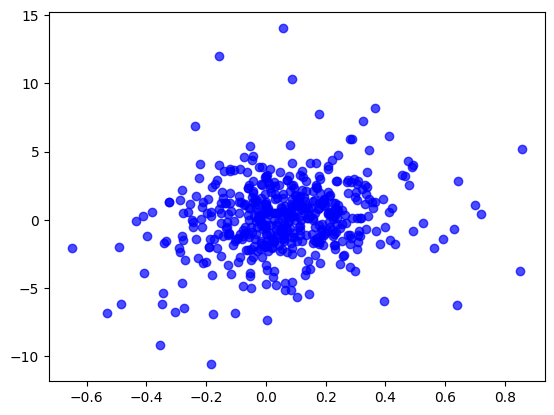

In [4790]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp['all_score'], relation_gp['delta'], color='blue', alpha=0.7)

In [4791]:
def preprocess(relation_gp, feat_cols, seq_length=50, offset=0):
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(relation_gp[feat_cols])

    X = []
    y = []
    for i in range(seq_length+offset, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1).to(device)

    split_index = int(len(X) * 0.95)
    X, X_test = X[:split_index], X[split_index:]
    y, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)

    return X, y, X_train, X_val, X_test, y_train, y_val, y_test

In [4792]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])

    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [4793]:
feat_dict = {
    'AAPL': ['neg_score', 'prv_close', '50_ma', 'delta'],
    'GOOGL': ['neg_score', 'prv_close', '50_ma', 'delta'],
    'other': ['neg_score', 'prv_close', 'delta'],
}
epoch_dict = {
    'other': 1000,
}

In [4794]:
feat_cols = feat_dict[ticker] if ticker in feat_dict else feat_dict['other']
model = SimpleLSTM(feat_size=[len(feat_cols), 32, 64, 1], layers=2, dropout=0.5).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocess(relation_gp, feat_cols)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([407, 50, 4]),
 torch.Size([22, 50, 4]),
 torch.Size([23, 50, 4]),
 torch.Size([407, 1]),
 torch.Size([22, 1]),
 torch.Size([23, 1]))

In [4795]:
num_epochs = epoch_dict[ticker] if ticker in epoch_dict else epoch_dict['other']
train_loss = []
val_loss = []
test_loss = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        train_loss.append(loss.item())
        val_loss.append(criterion(model(X_val), y_val).item())
        test_loss.append(criterion(model(X_test), y_test).item())
        if len(train_loss) >= 10:
            print(f"Epoch {epoch}, Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}, Test Loss: {np.mean(test_loss):.4f}")
            train_loss.clear()
            val_loss.clear()
            test_loss.clear()


Epoch 9, Train Loss: 0.8970, Val Loss: 1.1354, Test Loss: 1.2716
Epoch 19, Train Loss: 0.8862, Val Loss: 1.1630, Test Loss: 1.2864
Epoch 29, Train Loss: 0.8706, Val Loss: 1.2314, Test Loss: 1.2670
Epoch 39, Train Loss: 0.8378, Val Loss: 1.2937, Test Loss: 1.4339
Epoch 49, Train Loss: 0.8096, Val Loss: 1.3020, Test Loss: 1.5737
Epoch 59, Train Loss: 0.7809, Val Loss: 1.3502, Test Loss: 1.4171
Epoch 69, Train Loss: 0.7476, Val Loss: 1.4227, Test Loss: 1.3871
Epoch 79, Train Loss: 0.7340, Val Loss: 1.4455, Test Loss: 1.4194
Epoch 89, Train Loss: 0.7083, Val Loss: 1.4392, Test Loss: 1.4564
Epoch 99, Train Loss: 0.6911, Val Loss: 1.4120, Test Loss: 1.3993
Epoch 109, Train Loss: 0.6736, Val Loss: 1.3468, Test Loss: 1.3916
Epoch 119, Train Loss: 0.6585, Val Loss: 1.3304, Test Loss: 1.4182
Epoch 129, Train Loss: 0.6339, Val Loss: 1.2919, Test Loss: 1.5458
Epoch 139, Train Loss: 0.6197, Val Loss: 1.2436, Test Loss: 1.5773
Epoch 149, Train Loss: 0.6040, Val Loss: 1.2203, Test Loss: 1.5941
Epoch 

In [4796]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 1.2293
Std: 1.1405
Error Range: 0.9721


In [4797]:
def visualize(pred, ref, limit=1000):
    time = np.arange(len(pred))

    plt.plot(time[-limit:], pred[-limit:], label='Predicted Price', color='blue')
    plt.plot(time[-limit:], ref[-limit:], label='Real Price', color='orange')
    plt.xlabel('Trade Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

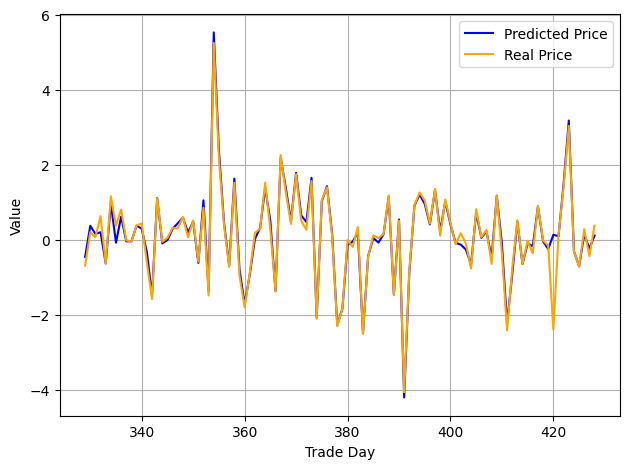

array([[1.        , 0.95782041],
       [0.95782041, 1.        ]])

In [4798]:
y_ref1 = y.squeeze().cpu()
with torch.no_grad():
    y_pred1 = model(X).squeeze().cpu()
visualize(y_pred1, y_ref1, 100)
np.corrcoef(y_pred1, y_ref1)

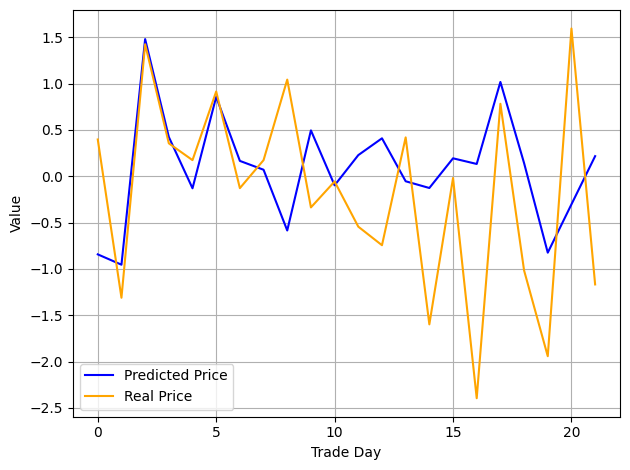

array([[1.        , 0.33396411],
       [0.33396411, 1.        ]])

In [4799]:
y_ref2 = y_val.squeeze().cpu()
with torch.no_grad():
    y_pred2 = model(X_val).squeeze().cpu()
visualize(y_pred2, y_ref2)
np.corrcoef(y_pred2, y_ref2)

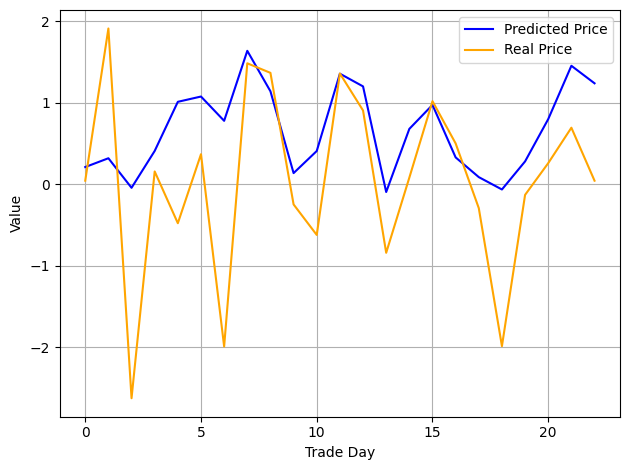

array([[1.        , 0.58081799],
       [0.58081799, 1.        ]])

In [4800]:
y_ref3 = y_test.squeeze().cpu()
with torch.no_grad():
    y_pred3 = model(X_test).squeeze().cpu()
visualize(y_pred3, y_ref3)
np.corrcoef(y_pred3, y_ref3)

In [4801]:
aveg_error1 = np.abs(y_pred1 - y_ref1).mean()
aveg_delta1 = np.abs(y_ref1).mean()
aveg_error1 / aveg_delta1, aveg_delta1

(tensor(0.2079), tensor(0.7008))